In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

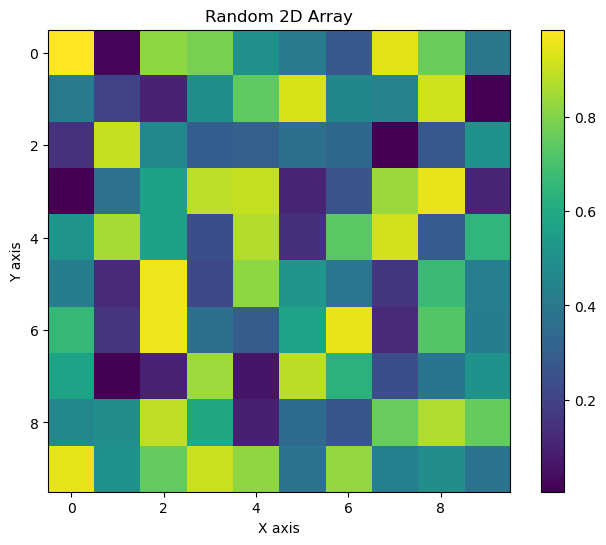

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                  FC_RESERVOIR=False):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight
        self.FC_RESERVOIR = FC_RESERVOIR

        self.out_channel = 1

        # 파라미터 
        if self.FC_RESERVOIR == True:
            self.reservoir = nn.Linear(in_features=self.in_channel*self.in_spike_size*self.in_spike_size, out_features=self.in_channel*self.in_spike_size*self.in_spike_size, bias=True)
        else:
            self.reservoir = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                            kernel_size=self.receptive_size, 
                                            stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.reservoir.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.reservoir.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # depthwise conv reservoir: pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            # fc conv reservoir: pre_spike[t] [batch_size, in_channel*in_spike_size*in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
                
            recurrent_current = self.reservoir(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1,
                 no_reservoir = False, FC_RESERVOIR=False):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.no_reservoir = no_reservoir
        self.FC_RESERVOIR = FC_RESERVOIR

        if self.no_reservoir == False:
            self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight,
                                       FC_RESERVOIR=FC_RESERVOIR)
        
        self.classifier = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        assert self.TIME_STEP == x.size(1), f"Time step mismatch: {x.size(1)} vs {self.TIME_STEP}"

        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        if (self.FC_RESERVOIR == True):
            x = x.reshape(x.size(0), x.size(1), -1)

        if self.no_reservoir == False:
            with torch.no_grad():
                x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape

        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.classifier(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        
        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)

        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        exclude_class = 10
        train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
        test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
    
        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}


    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [8]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Val Accuracy: {val_accuracy:.2f}%")


In [9]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, 
                            no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        wandb.log({"epoch": epoch})
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [10]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False)

In [11]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '2', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False, FC_RESERVOIR=False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    FC_RESERVOIR  =  wandb.config.FC_RESERVOIR
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir, FC_RESERVOIR=FC_RESERVOIR)



which_data_hyper = 'DVS_GESTURE' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': which_data_hyper,
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"min": 0.00001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"min": 0.25, "max": 1.0},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [20]},
        "IMAGE_SIZE": {"values": [16,32,48,128]},
        "dvs_duration": {"values": [100000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
        "FC_RESERVOIR": {"values": [True]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: sxt07a51
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/sxt07a51


wandb: Agent Starting Run: 4hf9343k with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.6740985954392293
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05547339875693387
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 1.727411919624344
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.25%
Test loss: 4.612, Val Accuracy: 51.14%
Epoch 2
Train Accuracy: 68.92%
Test loss: 4.719, Val Accuracy: 46.21%
Epoch 3
Train Accuracy: 77.46%
Test loss: 2.386, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 89.15%
Test loss: 3.833, Val Accuracy: 45.83%
Epoch 5
Train Accuracy: 88.96%
Test loss: 1.974, Val Accuracy: 63.26%
Epoch 6
Train Accuracy: 98.14%
Test loss: 2.050, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.701, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 99.81%
Test loss: 1.728, Val Accuracy: 63.64%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.804, Val Accuracy: 63.26%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.796, Val Accuracy: 64.77%
Epoch 11
Train Accuracy: 100.00%
Test loss: 1.782, Val Accuracy: 63.64%
Epoch 12
Trai

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅█▆█▆▇▅██████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▃▁▅▁▇▆▇▇▇█▇█████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.77273


wandb: Agent Starting Run: wa37w5q6 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.8690162552626626
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.045639693271154864
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.159923164713908
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.62%
Test loss: 7.844, Val Accuracy: 48.11%
Epoch 2
Train Accuracy: 69.48%
Test loss: 5.123, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 85.71%
Test loss: 3.609, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 89.52%
Test loss: 4.923, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 93.60%
Test loss: 2.927, Val Accuracy: 62.50%
Epoch 6
Train Accuracy: 97.50%
Test loss: 3.735, Val Accuracy: 56.44%
Epoch 7
Train Accuracy: 98.52%
Test loss: 2.863, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 99.72%
Test loss: 2.968, Val Accuracy: 62.12%
Epoch 9
Train Accuracy: 99.44%
Test loss: 3.492, Val Accuracy: 56.06%
Epoch 10
Train Accuracy: 99.91%
Test loss: 2.888, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▆▇▇▇█▇██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▄▆▅▇▅▇▇▅███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,63.63636


wandb: Agent Starting Run: ttbyradd with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5556530188550081
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.004276273809677299
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.1346743930260854
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.38%
Test loss: 1.952, Val Accuracy: 36.36%
Epoch 2
Train Accuracy: 46.57%
Test loss: 1.603, Val Accuracy: 45.45%
Epoch 3
Train Accuracy: 54.45%
Test loss: 1.546, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 58.72%
Test loss: 1.417, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 63.36%
Test loss: 1.403, Val Accuracy: 54.17%
Epoch 6
Train Accuracy: 62.89%
Test loss: 1.344, Val Accuracy: 53.41%
Epoch 7
Train Accuracy: 68.65%
Test loss: 1.306, Val Accuracy: 56.82%
Epoch 8
Train Accuracy: 69.20%
Test loss: 1.322, Val Accuracy: 54.92%
Epoch 9
Train Accuracy: 72.17%
Test loss: 1.302, Val Accuracy: 58.33%
Epoch 10
Train Accuracy: 72.82%
Test loss: 1.271, Val Accuracy: 56.82%
Epoch 11
Train Accuracy: 74.03%
Test loss: 1.254, Val Accuracy: 60.61%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▅▆▆▅▅▆▆▅▆▇▆▆▆█▅▆▇▇▇▇▇▇▆██▆▇██▇▇▆▇█▇▇
tr_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████
val_accuracy,▁▃▅▄▅▅▆▆▆▆▇▇▇▇▇██▇██
epoch,19
iter_accuracy,77.77778
tr_accuracy,83.02412
val_accuracy,64.77273


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cu34ykbc with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9743858223456344
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03792103463829028
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.9625781791957606
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.74%
Test loss: 1.749, Val Accuracy: 38.64%
Epoch 2
Train Accuracy: 48.24%
Test loss: 2.029, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 55.47%
Test loss: 1.457, Val Accuracy: 51.89%
Epoch 4
Train Accuracy: 63.27%
Test loss: 1.855, Val Accuracy: 53.41%
Epoch 5
Train Accuracy: 65.68%
Test loss: 1.457, Val Accuracy: 53.03%
Epoch 6
Train Accuracy: 68.00%
Test loss: 1.509, Val Accuracy: 59.09%
Epoch 7
Train Accuracy: 74.95%
Test loss: 1.416, Val Accuracy: 55.30%
Epoch 8
Train Accuracy: 76.99%
Test loss: 1.474, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 76.44%
Test loss: 1.359, Val Accuracy: 62.12%
Epoch 10
Train Accuracy: 79.78%
Test loss: 1.584, Val Accuracy: 69.32%
Epoch 11
Train Accuracy: 80.71%
Test loss: 1.311, Val Accuracy: 64.39%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▄▅▅▅▅▆▅▆▇▇▇▇▆▇▇▇▇▇▇▇█▇█▇█▇██▇███▇███
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
val_accuracy,▁▃▄▄▄▆▅▇▆█▇▇▇█▇█▇███
epoch,19
iter_accuracy,92.59259
tr_accuracy,91.09462
val_accuracy,67.80303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 51uwbbem with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8559067510249495
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09723766838059417
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.6022544115808328
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 30.71%
Test loss: 1.710, Val Accuracy: 45.08%
Epoch 2
Train Accuracy: 57.61%
Test loss: 1.263, Val Accuracy: 54.92%
Epoch 3
Train Accuracy: 70.96%
Test loss: 1.275, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 77.18%
Test loss: 1.223, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 79.96%
Test loss: 1.183, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 82.93%
Test loss: 1.130, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 89.89%
Test loss: 1.158, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 94.06%
Test loss: 1.201, Val Accuracy: 67.05%
Epoch 9
Train Accuracy: 94.71%
Test loss: 1.242, Val Accuracy: 67.42%
Epoch 10
Train Accuracy: 95.83%
Test loss: 1.228, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▅▆▅▆▆▇▇▇▇▇██▇█████████████████████
tr_accuracy,▁▄▅▆▆▆▇▇████████████
val_accuracy,▁▄▄▅▅▆▇▇▇▆▆▇▇█▇█▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,68.18182


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: to6dr1ft with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6790656144412819
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06241633084178439
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.213042369989743
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.09%
Test loss: 1.741, Val Accuracy: 37.50%
Epoch 2
Train Accuracy: 48.24%
Test loss: 1.717, Val Accuracy: 45.83%
Epoch 3
Train Accuracy: 56.77%
Test loss: 2.214, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 65.40%
Test loss: 1.396, Val Accuracy: 54.92%
Epoch 5
Train Accuracy: 70.69%
Test loss: 1.494, Val Accuracy: 53.79%
Epoch 6
Train Accuracy: 72.26%
Test loss: 1.641, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 76.07%
Test loss: 1.230, Val Accuracy: 58.71%
Epoch 8
Train Accuracy: 80.43%
Test loss: 1.500, Val Accuracy: 67.80%
Epoch 9
Train Accuracy: 84.14%
Test loss: 1.355, Val Accuracy: 63.26%
Epoch 10
Train Accuracy: 87.01%
Test loss: 1.270, Val Accuracy: 68.94%
Epoch 11
Train Accuracy: 88.03%
Test loss: 1.514, Val Accuracy: 69.70%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▄▆▆▆▆▅▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█████████████
tr_accuracy,▁▄▄▅▆▆▆▇▇▇▇▇█▇██████
val_accuracy,▁▃▅▅▅▆▆█▇███▇██▇█▇██
epoch,19
iter_accuracy,96.2963
tr_accuracy,96.01113
val_accuracy,67.80303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e85udzks with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8833315310057414
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07517382002769767
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.870413881604266
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.73%
Test loss: 1.849, Val Accuracy: 43.56%
Epoch 2
Train Accuracy: 49.07%
Test loss: 2.449, Val Accuracy: 37.50%
Epoch 3
Train Accuracy: 55.47%
Test loss: 2.407, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 60.67%
Test loss: 2.716, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 59.93%
Test loss: 1.073, Val Accuracy: 49.24%
Epoch 6
Train Accuracy: 63.45%
Test loss: 1.473, Val Accuracy: 51.14%
Epoch 7
Train Accuracy: 70.13%
Test loss: 3.273, Val Accuracy: 54.17%
Epoch 8
Train Accuracy: 71.99%
Test loss: 2.473, Val Accuracy: 51.52%
Epoch 9
Train Accuracy: 76.90%
Test loss: 0.951, Val Accuracy: 60.61%
Epoch 10
Train Accuracy: 80.52%
Test loss: 2.505, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███▇███
tr_accuracy,▁▄▄▅▅▅▆▆▆▆▇▇▇▇▇█████
val_accuracy,▂▁▄▃▃▄▄▄▆▅▇▆▆▅▇▆█▅█▇
epoch,19
iter_accuracy,100.0
tr_accuracy,96.28942
val_accuracy,67.80303


wandb: Agent Starting Run: 4l83tkzk with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.5801692881306519
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08799609541614789
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.56033835265122
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.19%
Test loss: 1.875, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 53.15%
Test loss: 1.595, Val Accuracy: 48.86%
Epoch 3
Train Accuracy: 61.22%
Test loss: 1.901, Val Accuracy: 50.76%
Epoch 4
Train Accuracy: 65.31%
Test loss: 1.553, Val Accuracy: 54.92%
Epoch 5
Train Accuracy: 70.78%
Test loss: 1.582, Val Accuracy: 55.68%
Epoch 6
Train Accuracy: 77.18%
Test loss: 1.090, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 82.10%
Test loss: 1.662, Val Accuracy: 62.88%
Epoch 8
Train Accuracy: 82.84%
Test loss: 1.344, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 83.77%
Test loss: 1.186, Val Accuracy: 65.15%
Epoch 10
Train Accuracy: 85.44%
Test loss: 1.911, Val Accuracy: 64.77%
Epoch 11
Train Accuracy: 86.55%
Test loss: 0.931, Val Accuracy: 65.91%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇███████
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇▇▇█▇████
val_accuracy,▁▃▃▄▅█▆▇▇▇▇███▇▇▇▇██
epoch,19
iter_accuracy,98.14815
tr_accuracy,96.38219
val_accuracy,67.80303


wandb: Agent Starting Run: khegi3ys with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8981989595623758
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07026589312713895
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.5169247674618501
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 17.35%
Test loss: 2.166, Val Accuracy: 26.52%
Epoch 2
Train Accuracy: 34.97%
Test loss: 1.860, Val Accuracy: 47.73%
Epoch 3
Train Accuracy: 52.04%
Test loss: 1.629, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 56.03%
Test loss: 1.582, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 58.91%
Test loss: 1.711, Val Accuracy: 50.76%
Epoch 6
Train Accuracy: 62.89%
Test loss: 1.660, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 64.84%
Test loss: 1.480, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 69.94%
Test loss: 1.486, Val Accuracy: 56.06%
Epoch 9
Train Accuracy: 67.72%
Test loss: 1.557, Val Accuracy: 53.41%
Epoch 10
Train Accuracy: 71.34%
Test loss: 1.422, Val Accuracy: 57.20%
Epoch 11
Train Accuracy: 70.04%
Test loss: 1.457, Val Accuracy: 58.71%
Epoch 12
Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▆▅▆▅▆▆▇▆▇▇▇▆▇▇▇▆▇▇▇▇▇▇▇█▇██▇█▇█▇█▇
tr_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▅▆▆▆▆▇▇▇▇█▇████▇███
epoch,19
iter_accuracy,75.92593
tr_accuracy,80.05566
val_accuracy,58.33333


wandb: Agent Starting Run: 1bbilfej with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8913605529398918
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.096065055641277
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.631116649774595
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.38%
Test loss: 6.377, Val Accuracy: 30.30%
Epoch 2
Train Accuracy: 49.26%
Test loss: 3.946, Val Accuracy: 46.21%
Epoch 3
Train Accuracy: 70.41%
Test loss: 3.890, Val Accuracy: 55.30%
Epoch 4
Train Accuracy: 81.54%
Test loss: 3.489, Val Accuracy: 54.17%
Epoch 5
Train Accuracy: 83.95%
Test loss: 2.410, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 92.58%
Test loss: 5.397, Val Accuracy: 58.33%
Epoch 7
Train Accuracy: 95.18%
Test loss: 6.818, Val Accuracy: 60.61%
Epoch 8
Train Accuracy: 95.64%
Test loss: 3.517, Val Accuracy: 63.26%
Epoch 9
Train Accuracy: 97.87%
Test loss: 2.831, Val Accuracy: 65.53%
Epoch 10
Train Accuracy: 99.17%
Test loss: 3.326, Val Accuracy: 66.29%
Epoch 11
Train Accuracy: 99.35%
Test loss: 2.598, Val Accuracy: 65.91%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▂▄▆▅▆▇▆▇█▇▇▇▇█████████████████████████
tr_accuracy,▁▂▅▆▆▇▇█████████████
val_accuracy,▁▄▆▆▇▆▇▇████████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.15152


wandb: Agent Starting Run: mpwma4b5 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.576204481489534
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09056504549466568
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.4616597715898365
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=512, out_features=512, bias=True)
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.77%
Test loss: 2.251, Val Accuracy: 19.70%
Epoch 2
Train Accuracy: 31.17%
Test loss: 1.747, Val Accuracy: 47.35%
Epoch 3
Train Accuracy: 51.30%
Test loss: 1.803, Val Accuracy: 40.53%
Epoch 4
Train Accuracy: 53.99%
Test loss: 1.482, Val Accuracy: 46.59%
Epoch 5
Train Accuracy: 56.49%
Test loss: 1.782, Val Accuracy: 52.65%
Epoch 6
Train Accuracy: 64.01%
Test loss: 1.535, Val Accuracy: 51.52%
Epoch 7
Train Accuracy: 63.17%
Test loss: 1.523, Val Accuracy: 50.76%
Epoch 8
Train Accuracy: 65.68%
Test loss: 1.544, Val Accuracy: 54.55%
Epoch 9
Train Accuracy: 71.52%
Test loss: 1.447, Val Accuracy: 57.20%
Epoch 10
Train Accuracy: 72.54%
Test loss: 1.358, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▆▄▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█▇▇███▇██▇████
tr_accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇█▇█████
val_accuracy,▁▆▄▅▆▆▆▇▇▇▇▇▇▇███▇▇█
epoch,19
iter_accuracy,83.33333
tr_accuracy,81.81818
val_accuracy,61.74242


wandb: Agent Starting Run: av8r07yw with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6782306033941309
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03530038023684128
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 0.7038956464291648
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.80%
Test loss: 1.828, Val Accuracy: 40.53%
Epoch 2
Train Accuracy: 50.46%
Test loss: 1.630, Val Accuracy: 45.83%
Epoch 3
Train Accuracy: 60.95%
Test loss: 1.489, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 66.88%
Test loss: 1.378, Val Accuracy: 51.52%
Epoch 5
Train Accuracy: 74.58%
Test loss: 1.337, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 77.83%
Test loss: 1.313, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 79.31%
Test loss: 1.235, Val Accuracy: 64.39%
Epoch 8
Train Accuracy: 83.40%
Test loss: 1.276, Val Accuracy: 57.95%
Epoch 9
Train Accuracy: 84.88%
Test loss: 1.188, Val Accuracy: 65.15%
Epoch 10
Train Accuracy: 88.78%
Test loss: 1.257, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▄▅▄▅▆▇▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██████████████
tr_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇████████
val_accuracy,▁▂▃▄▆▆▇▆▇▇▇▇██▇█████
epoch,19
iter_accuracy,94.44444
tr_accuracy,96.19666
val_accuracy,67.42424


wandb: Agent Starting Run: eqvg1pcw with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7162001023744953
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06538796996712694
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.006998530923227
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 35.71%
Test loss: 2.299, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 66.60%
Test loss: 1.711, Val Accuracy: 47.73%
Epoch 3
Train Accuracy: 82.37%
Test loss: 1.238, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 92.95%
Test loss: 1.855, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 94.81%
Test loss: 1.307, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 98.89%
Test loss: 1.325, Val Accuracy: 61.74%
Epoch 7
Train Accuracy: 99.81%
Test loss: 1.273, Val Accuracy: 61.36%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.326, Val Accuracy: 62.88%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.112, Val Accuracy: 64.77%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.201, Val Accuracy: 65.53%
Epoch 11
Train Accuracy: 100.00%
Test loss: 1.311, Val Accuracy: 61.74%
Epoch 12
Tra

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▄▇▇▇█▇██████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▃▆▃▇▇▇▇██▇▇███▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,63.25758


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nt4425nb with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.2659872044408107
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0014329652343655496
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.962917615311547
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 14.19%
Test loss: 2.154, Val Accuracy: 25.00%
Epoch 2
Train Accuracy: 30.33%
Test loss: 2.017, Val Accuracy: 40.91%
Epoch 3
Train Accuracy: 49.91%
Test loss: 1.500, Val Accuracy: 49.24%
Epoch 4
Train Accuracy: 60.30%
Test loss: 1.493, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 59.74%
Test loss: 1.708, Val Accuracy: 48.48%
Epoch 6
Train Accuracy: 61.41%
Test loss: 1.742, Val Accuracy: 49.24%
Epoch 7
Train Accuracy: 63.82%
Test loss: 1.536, Val Accuracy: 53.41%
Epoch 8
Train Accuracy: 68.09%
Test loss: 1.470, Val Accuracy: 56.44%
Epoch 9
Train Accuracy: 69.29%
Test loss: 1.550, Val Accuracy: 59.85%
Epoch 10
Train Accuracy: 71.52%
Test loss: 1.532, Val Accuracy: 54.55%
Epoch 11
Train Accuracy: 72.36%
Test loss: 1.498, Val Accuracy: 53.03%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▄▄▅▅▆▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
tr_accuracy,▁▃▅▆▆▆▆▇▇▇▇▇▇▇▇█████
val_accuracy,▁▄▅▆▅▅▆▇▇▆▆▇▇▇▇████▇
epoch,19
iter_accuracy,88.88889
tr_accuracy,81.16883
val_accuracy,61.36364


wandb: Agent Starting Run: i4h32b3c with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6574236302650368
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.07030066242512521
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.174177844601864
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 15.185, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 41.09%
Test loss: 14.063, Val Accuracy: 32.20%
Epoch 3
Train Accuracy: 45.08%
Test loss: 13.652, Val Accuracy: 46.21%
Epoch 4
Train Accuracy: 56.96%
Test loss: 8.270, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 69.76%
Test loss: 5.948, Val Accuracy: 58.71%
Epoch 6
Train Accuracy: 75.70%
Test loss: 7.994, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 80.43%
Test loss: 4.744, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 84.32%
Test loss: 3.094, Val Accuracy: 59.85%
Epoch 9
Train Accuracy: 84.69%
Test loss: 2.990, Val Accuracy: 62.50%
Epoch 10
Train Accuracy: 85.44%
Test loss: 3.461, 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▄▃▄▄▄▆▆▆▆▇▆▇▇▇▇▆▇▇█▇█▇███████████████
tr_accuracy,▁▃▃▄▅▆▆▇▇▇▇█████████
val_accuracy,▁▂▄▅▆▇▆▆▆▆▆▆▇▆▇███▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,98.79406
val_accuracy,65.15152


wandb: Agent Starting Run: owg2h9z2 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5005877424466041
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.06888534143574691
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.8228207920651047
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 49.81%
Test loss: 6.313, Val Accuracy: 59.47%
Epoch 2
Train Accuracy: 72.08%
Test loss: 16.736, Val Accuracy: 45.08%
Epoch 3
Train Accuracy: 79.50%
Test loss: 5.818, Val Accuracy: 67.05%
Epoch 4
Train Accuracy: 90.26%
Test loss: 5.591, Val Accuracy: 70.08%
Epoch 5
Train Accuracy: 89.42%
Test loss: 6.699, Val Accuracy: 66.67%
Epoch 6
Train Accuracy: 96.01%
Test loss: 8.014, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 94.81%
Test loss: 6.220, Val Accuracy: 64.02%
Epoch 8
Train Accuracy: 96.94%
Test loss: 5.376, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 98.70%
Test loss: 6.996, Val Accuracy: 63.64%
Epoch 10
Train Accuracy: 99.35%
Test loss: 5.766, Val Accuracy: 66.67%
Epoch 11
Train Accuracy: 99.91%
Test loss: 5.852, Val Accuracy: 64.77%
Epoch 12
Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▂▁▆▆▃▅█▆▅▇██▇▇▆▇████████████████████████
tr_accuracy,▁▄▅▇▇▇▇█████████████
val_accuracy,▅▁▇█▇▆▆▇▆▇▇▇▆▆▆▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.77273


wandb: Agent Starting Run: 725hi74f with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7233050226049862
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09887958479950248
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.29661191469215
wandb: 	rate_coding: False
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.51%
Test loss: 1.880, Val Accuracy: 43.94%
Epoch 2
Train Accuracy: 63.17%
Test loss: 2.054, Val Accuracy: 48.48%
Epoch 3
Train Accuracy: 77.92%
Test loss: 1.566, Val Accuracy: 50.76%
Epoch 4
Train Accuracy: 85.62%
Test loss: 2.214, Val Accuracy: 44.70%
Epoch 5
Train Accuracy: 89.80%
Test loss: 1.188, Val Accuracy: 65.15%
Epoch 6
Train Accuracy: 93.88%
Test loss: 1.503, Val Accuracy: 59.47%
Epoch 7
Train Accuracy: 97.68%
Test loss: 1.604, Val Accuracy: 55.30%
Epoch 8
Train Accuracy: 99.35%
Test loss: 1.364, Val Accuracy: 61.36%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.292, Val Accuracy: 64.02%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.569, Val A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▆▆▆▇▇▇▇█████████████████████████████
tr_accuracy,▁▄▆▆▇▇██████████████
val_accuracy,▁▃▃▁█▆▅▇█▆▇▆█▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,61.74242


wandb: Agent Starting Run: tl108w9o with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6328640665731314
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02774431520083744
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 3.750236394656167
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.10%
Test loss: 1.693, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 56.49%
Test loss: 1.411, Val Accuracy: 48.11%
Epoch 3
Train Accuracy: 67.72%
Test loss: 1.416, Val Accuracy: 49.62%
Epoch 4
Train Accuracy: 71.06%
Test loss: 1.549, Val Accuracy: 57.58%
Epoch 5
Train Accuracy: 74.03%
Test loss: 1.366, Val Accuracy: 59.09%
Epoch 6
Train Accuracy: 82.00%
Test loss: 1.380, Val Accuracy: 62.12%
Epoch 7
Train Accuracy: 87.11%
Test loss: 1.340, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 91.47%
Test loss: 1.193, Val Accuracy: 68.56%
Epoch 9
Train Accuracy: 93.41%
Test loss: 1.220, Val Accuracy: 69.70%
Epoch 10
Train Accuracy: 95.83%
Test loss: 1.505, Val Accuracy: 65.91%
Epoch 11
Train Accuracy: 97.31%
Test loss: 1.299, Val Accuracy: 67.80%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▄▅▅▆▆▆▇▆▇▇▇▇███████████████████████
tr_accuracy,▁▄▅▅▅▆▇▇▇███████████
val_accuracy,▁▃▃▅▅▆▇██▇█▇█▇███▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,68.18182


wandb: Agent Starting Run: psv1ohzz with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6865489563619572
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01788143597300052
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.705602089366033
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.68%
Test loss: 1.587, Val Accuracy: 42.42%
Epoch 2
Train Accuracy: 53.06%
Test loss: 1.436, Val Accuracy: 46.59%
Epoch 3
Train Accuracy: 62.89%
Test loss: 1.276, Val Accuracy: 53.79%
Epoch 4
Train Accuracy: 70.69%
Test loss: 1.351, Val Accuracy: 59.85%
Epoch 5
Train Accuracy: 77.46%
Test loss: 1.357, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 80.89%
Test loss: 1.154, Val Accuracy: 65.53%
Epoch 7
Train Accuracy: 87.11%
Test loss: 1.204, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 91.74%
Test loss: 1.315, Val Accuracy: 58.71%
Epoch 9
Train Accuracy: 92.67%
Test loss: 1.338, Val Accuracy: 57.20%
Epoch 10
Train Accuracy: 93.88%
Test loss: 1.531, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▃▄▅▆▆▅▇▆▆▆▇█▇▇█▇▇▇███████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇██████████
val_accuracy,▁▂▄▆▆▇▆▅▅▆▇▆▆█▆▆▇█▆▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.25788
val_accuracy,64.39394


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 27yvblao with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.7563691532519725
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.03352794935950817
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.823660148845965
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 44.43%
Test loss: 3.829, Val Accuracy: 50.38%
Epoch 2
Train Accuracy: 72.26%
Test loss: 5.295, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 78.39%
Test loss: 4.229, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 84.88%
Test loss: 4.019, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 90.07%
Test loss: 2.490, Val Accuracy: 60.98%
Epoch 6
Train Accuracy: 97.87%
Test loss: 2.123, Val Accuracy: 65.15%
Epoch 7
Train Accuracy: 99.35%
Test loss: 1.852, Val Accuracy: 69.70%
Epoch 8
Train Accuracy: 99.26%
Test loss: 2.537, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 100.00%
Test loss: 2.086, Val Accuracy: 66.67%
Epoch 10
Train Accuracy: 100.00%
Test loss: 2.026, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▄▆▇▆▆▇▇████▇█████████████████████████
tr_accuracy,▁▅▅▆▇███████████████
val_accuracy,▁▁▅▄▅▆█▆▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: 9lzweo02 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.4122643903972408
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08126748888887031
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.692594149436373
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 34.97%
Test loss: 6.277, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 71.24%
Test loss: 7.264, Val Accuracy: 46.21%
Epoch 3
Train Accuracy: 76.44%
Test loss: 9.493, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 82.19%
Test loss: 5.057, Val Accuracy: 55.68%
Epoch 5
Train Accuracy: 87.20%
Test loss: 4.233, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 93.78%
Test loss: 5.816, Val Accuracy: 54.92%
Epoch 7
Train Accuracy: 93.32%
Test loss: 4.078, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 98.70%
Test loss: 5.334, Val Accuracy: 58.33%
Epoch 9
Train Accuracy: 99.35%
Test loss: 4.719, Val Accuracy: 59.09%
Epoch 10
Train Accuracy: 99.17%
Test loss: 3.568, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▇▆▅▇▇▆█▇█▇█▆███████▇██████████████████
tr_accuracy,▁▅▅▆▇▇▇█████████████
val_accuracy,▃▁▂▅▇▄▇▅▆▇▄█▇▇▇▇▇▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,64.01515


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5r9r5ohe with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8807479328738474
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.09294563203905
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 3.7381989059415552
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.78%
Test loss: 18.475, Val Accuracy: 22.73%
Epoch 2
Train Accuracy: 32.28%
Test loss: 19.971, Val Accuracy: 31.06%
Epoch 3
Train Accuracy: 53.15%
Test loss: 15.308, Val Accuracy: 33.71%
Epoch 4
Train Accuracy: 61.69%
Test loss: 16.554, Val Accuracy: 48.48%
Epoch 5
Train Accuracy: 69.48%
Test loss: 6.196, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 76.35%
Test loss: 10.305, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 80.98%
Test loss: 7.953, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 83.77%
Test loss: 7.316, Val Accuracy: 58.71%
Epoch 9
Train Accuracy: 89.98%
Test loss: 7.323, Val Accuracy: 56.82%
Epoch 10
Train Accuracy: 92.58%
Test loss: 6.548

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▃▃▅▅▅▆▅▆▆▇▇▇▇▇▇█▇████████████████████
tr_accuracy,▁▂▄▅▅▆▆▇▇▇██████████
val_accuracy,▁▂▃▅▅▇▅▇▆▇▇▇▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.5303


wandb: Agent Starting Run: 4iruolld with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4103587347918811
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012338173264345524
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.023504959789864
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.94%
Test loss: 2.249, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 62.62%
Test loss: 1.434, Val Accuracy: 59.85%
Epoch 3
Train Accuracy: 78.01%
Test loss: 0.956, Val Accuracy: 62.50%
Epoch 4
Train Accuracy: 80.89%
Test loss: 1.035, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 84.32%
Test loss: 1.174, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 88.68%
Test loss: 1.092, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 94.25%
Test loss: 0.955, Val Accuracy: 66.29%
Epoch 8
Train Accuracy: 95.36%
Test loss: 1.219, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 96.38%
Test loss: 1.000, Val Accuracy: 71.97%
Epoch 10
Train Accuracy: 97.22%
Test loss: 1.197, Val Accuracy: 71.97%
Epoch 11
Train Accuracy: 97.96%
Test loss: 1.048, Val Accuracy: 70.45%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▅▆▆▆▆▇▇▇█████████████████████████████
tr_accuracy,▁▄▆▆▆▇▇▇████████████
val_accuracy,▁▄▅▅▅▆▆▇██▇██▇▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,68.93939


wandb: Agent Starting Run: l1bfjawp with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3651960863653029
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08873277940652792
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.811372684080855
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 22.82%
Test loss: 1.676, Val Accuracy: 42.05%
Epoch 2
Train Accuracy: 50.19%
Test loss: 1.498, Val Accuracy: 45.08%
Epoch 3
Train Accuracy: 59.93%
Test loss: 1.480, Val Accuracy: 54.17%
Epoch 4
Train Accuracy: 65.40%
Test loss: 1.361, Val Accuracy: 55.30%
Epoch 5
Train Accuracy: 69.20%
Test loss: 1.345, Val Accuracy: 54.17%
Epoch 6
Train Accuracy: 71.99%
Test loss: 1.186, Val Accuracy: 60.98%
Epoch 7
Train Accuracy: 74.77%
Test loss: 1.218, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 76.90%
Test loss: 1.417, Val Accuracy: 59.09%
Epoch 9
Train Accuracy: 78.85%
Test loss: 1.220, Val Accuracy: 62.88%
Epoch 10
Train Accuracy: 79.87%
Test loss: 1.197, Val Accuracy: 61.36%
Epoch 11
Train Accuracy: 81.35%
Test loss: 1.207, Val Accuracy: 64.02%
Epoch 12
Train Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▄▅▆▆▅▆▆▆▆▆▆▆▇▇▇▆▇▇█▇▇▇▇▇▇▇▆▇▇▇█▇▇█▇▇█
tr_accuracy,▁▄▅▆▆▆▇▇▇▇▇█████████
val_accuracy,▁▂▅▅▅▇▇▆▇▇██▇▇▇▇██▇▆
epoch,19
iter_accuracy,94.44444
tr_accuracy,88.0334
val_accuracy,59.84848


wandb: Agent Starting Run: ttl2yv2q with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7798913704179237
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.050514215383424856
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.318676042191916
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 32.84%
Test loss: 1.447, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 59.65%
Test loss: 2.024, Val Accuracy: 49.24%
Epoch 3
Train Accuracy: 68.09%
Test loss: 1.718, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 82.10%
Test loss: 1.680, Val Accuracy: 56.44%
Epoch 5
Train Accuracy: 90.26%
Test loss: 1.321, Val Accuracy: 64.77%
Epoch 6
Train Accuracy: 95.83%
Test loss: 1.454, Val Accuracy: 58.33%
Epoch 7
Train Accuracy: 97.59%
Test loss: 1.495, Val Accuracy: 57.95%
Epoch 8
Train Accuracy: 97.96%
Test loss: 1.647, Val Accuracy: 59.47%
Epoch 9
Train Accuracy: 99.54%
Test loss: 1.418, Val Accuracy: 59.47%
Epoch 10
Train Accuracy: 99.54%
Test loss: 1.536, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▄▅▅▅▆▆▇▇▇█████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████
val_accuracy,▁▃▃▅█▆▆▆▆▇▆▇▇▆▆▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,61.36364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lx0noc7o with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7150045624850768
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.08822955993065013
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.835472015117097
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=512, out_features=512, bias=True)
  )
  (classifier): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.99%
Test loss: 1.648, Val Accuracy: 37.12%
Epoch 2
Train Accuracy: 47.59%
Test loss: 1.673, Val Accuracy: 39.39%
Epoch 3
Train Accuracy: 55.66%
Test loss: 1.541, Val Accuracy: 48.86%
Epoch 4
Train Accuracy: 61.78%
Test loss: 1.513, Val Accuracy: 51.14%
Epoch 5
Train Accuracy: 65.40%
Test loss: 1.248, Val Accuracy: 56.06%
Epoch 6
Train Accuracy: 70.87%
Test loss: 1.223, Val Accuracy: 55.68%
Epoch 7
Train Accuracy: 75.51%
Test loss: 1.366, Val Accuracy: 53.79%
Epoch 8
Train Accuracy: 76.62%
Test loss: 1.346, Val Accuracy: 57.95%
Epoch 9
Train Accuracy: 78.76%
Test loss: 1.315, Val Accuracy: 58.71%
Epoch 10
Train Accuracy: 80.80%
Test loss: 1.198, Val Accur

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▆▇▇▇██▇▇███▇██▇████████
tr_accuracy,▁▄▄▅▆▆▇▇▇▇▇▇██▇█████
val_accuracy,▁▂▄▅▇▆▆▇▇▇████▇▇████
epoch,19
iter_accuracy,87.03704
tr_accuracy,88.68275
val_accuracy,60.22727


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q68v16sg with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7615965393237909
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04721196732543512
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.1462857013937
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.97%
Test loss: 1.936, Val Accuracy: 41.67%
Epoch 2
Train Accuracy: 55.29%
Test loss: 1.716, Val Accuracy: 53.03%
Epoch 3
Train Accuracy: 59.65%
Test loss: 1.333, Val Accuracy: 55.30%
Epoch 4
Train Accuracy: 70.69%
Test loss: 1.566, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 74.49%
Test loss: 1.156, Val Accuracy: 59.85%
Epoch 6
Train Accuracy: 75.97%
Test loss: 1.285, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 79.41%
Test loss: 2.097, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 81.35%
Test loss: 1.366, Val Accuracy: 62.12%
Epoch 9
Train Accuracy: 85.81%
Test loss: 1.323, Val Accuracy: 68.18%
Epoch 10
Train Accuracy: 88.13%
Test loss: 1.455, Val Accuracy: 64.02%
Epoch 11
Train Accuracy: 90.63%
Test loss: 1.193, Val Accuracy: 68.94%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇█▇▇▇██████████████████
tr_accuracy,▁▄▄▅▆▆▆▆▇▇▇█████████
val_accuracy,▁▄▄▅▅▅▆▆▇▆▇▇▆█▇▇▇███
epoch,19
iter_accuracy,100.0
tr_accuracy,99.44341
val_accuracy,71.21212


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g0af8m5g with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9215690430295768
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.04554728485705515
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.368087526372907
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 21.52%
Test loss: 6.233, Val Accuracy: 35.23%
Epoch 2
Train Accuracy: 34.60%
Test loss: 12.580, Val Accuracy: 26.52%
Epoch 3
Train Accuracy: 40.54%
Test loss: 3.335, Val Accuracy: 46.59%
Epoch 4
Train Accuracy: 51.86%
Test loss: 7.580, Val Accuracy: 45.45%
Epoch 5
Train Accuracy: 64.94%
Test loss: 4.358, Val Accuracy: 48.11%
Epoch 6
Train Accuracy: 73.28%
Test loss: 8.680, Val Accuracy: 60.61%
Epoch 7
Train Accuracy: 80.24%
Test loss: 3.544, Val Accuracy: 61.74%
Epoch 8
Train Accuracy: 84.60%
Test loss: 3.058, Val Accuracy: 56.82%
Epoch 9
Train Accuracy: 88.22%
Test loss: 2.773, Val Accuracy: 61.74%
Epoch 10
Train Accuracy: 89.89%
Test loss: 3.402, Va

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇███████████████████
tr_accuracy,▁▂▃▄▅▆▆▇▇▇▇█████████
val_accuracy,▂▁▄▄▄▆▆▆▆▆▇▇▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,99.90724
val_accuracy,71.9697


wandb: Agent Starting Run: 5bnyf4ys with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8965708493746389
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.026515208540505267
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.8145790802641555
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 43.78%
Test loss: 2.174, Val Accuracy: 45.08%
Epoch 2
Train Accuracy: 64.47%
Test loss: 1.865, Val Accuracy: 54.55%
Epoch 3
Train Accuracy: 80.61%
Test loss: 1.756, Val Accuracy: 57.95%
Epoch 4
Train Accuracy: 88.22%
Test loss: 1.355, Val Accuracy: 58.71%
Epoch 5
Train Accuracy: 92.30%
Test loss: 2.348, Val Accuracy: 60.23%
Epoch 6
Train Accuracy: 96.47%
Test loss: 1.600, Val Accuracy: 67.80%
Epoch 7
Train Accuracy: 99.63%
Test loss: 1.285, Val Accuracy: 71.59%
Epoch 8
Train Accuracy: 99.72%
Test loss: 1.155, Val Accuracy: 74.24%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.989, Val Accuracy: 73.11%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.564, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▅▇▇▇█▇▇█████████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▃▄▄▅▆▇██▇██████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Agent Starting Run: 0e5q44k5 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8945125063938529
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0241113129798685
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.259714247820205
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.04%
Test loss: 2.329, Val Accuracy: 45.45%
Epoch 2
Train Accuracy: 55.19%
Test loss: 1.832, Val Accuracy: 56.44%
Epoch 3
Train Accuracy: 66.23%
Test loss: 1.492, Val Accuracy: 59.09%
Epoch 4
Train Accuracy: 72.63%
Test loss: 1.144, Val Accuracy: 66.29%
Epoch 5
Train Accuracy: 80.06%
Test loss: 2.070, Val Accuracy: 66.29%
Epoch 6
Train Accuracy: 86.18%
Test loss: 1.042, Val Accuracy: 62.88%
Epoch 7
Train Accuracy: 88.40%
Test loss: 1.338, Val Accuracy: 67.05%
Epoch 8
Train Accuracy: 93.23%
Test loss: 1.103, Val Accuracy: 68.94%
Epoch 9
Train Accuracy: 94.16%
Test loss: 1.429, Val Accuracy: 70.08%
Epoch 10
Train Accuracy: 96.10%
Test loss: 1.004, Val Accuracy: 66.67%
Epoch 11
Train Accuracy: 96.66%
Test loss: 1.307, Val Accuracy: 67.42%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▆▅▆▆▆▆▇▇▇▇█▇▇███████████████████████
tr_accuracy,▁▄▅▅▆▇▇▇▇███████████
val_accuracy,▁▄▅▇▇▆▇▇█▇▇▇▇█████▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,99.81447
val_accuracy,70.07576


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t98a58v1 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.823104789712981
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.015270343520033296
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.071241920874454
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.68%
Test loss: 1.415, Val Accuracy: 53.03%
Epoch 2
Train Accuracy: 63.45%
Test loss: 1.326, Val Accuracy: 57.58%
Epoch 3
Train Accuracy: 73.28%
Test loss: 1.181, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 78.76%
Test loss: 1.181, Val Accuracy: 58.33%
Epoch 5
Train Accuracy: 81.82%
Test loss: 1.241, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 87.01%
Test loss: 1.055, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 91.47%
Test loss: 1.082, Val Accuracy: 64.77%
Epoch 8
Train Accuracy: 93.88%
Test loss: 1.016, Val Accuracy: 66.29%
Epoch 9
Train Accuracy: 97.12%
Test loss: 1.099, Val Accuracy: 71.21%
Epoch 10
Train Accuracy: 98.33%
Test loss: 1.161, Val Accuracy: 70.45%
Epoch 11
Train Accuracy: 98.70%
Test loss: 1.118, Val Accuracy: 69.32%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▄▅▄▅▆▅▅▇▆▇▇▇▇▇█▇███████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇████████████
val_accuracy,▁▃▄▃▅▅▅▆▇▇▇▇█▇▆█▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Agent Starting Run: 4j3zyaun with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.9853215260742598
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.007352067767509232
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.28561863920332
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.96%
Test loss: 1.910, Val Accuracy: 47.73%
Epoch 2
Train Accuracy: 54.82%
Test loss: 1.415, Val Accuracy: 50.00%
Epoch 3
Train Accuracy: 60.48%
Test loss: 1.840, Val Accuracy: 48.48%
Epoch 4
Train Accuracy: 66.70%
Test loss: 1.264, Val Accuracy: 59.09%
Epoch 5
Train Accuracy: 74.30%
Test loss: 1.564, Val Accuracy: 62.12%
Epoch 6
Train Accuracy: 79.78%
Test loss: 1.298, Val Accuracy: 65.53%
Epoch 7
Train Accuracy: 81.08%
Test loss: 1.441, Val Accuracy: 62.50%
Epoch 8
Train Accuracy: 80.98%
Test loss: 1.285, Val Accuracy: 65.15%
Epoch 9
Train Accuracy: 83.67%
Test loss: 1.246, Val Accuracy: 64.02%
Epoch 10
Train Accuracy: 84.97%
Test loss: 1.277, Val Accuracy: 66.29%
Epoch 11
Train Accuracy: 85.06%
Test loss: 1.218, Val Accuracy: 67.42%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▄▅▅▅▆▆▆▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇████████████████
tr_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇████████
val_accuracy,▁▂▁▅▆▇▆▆▆▇▇▆█████▇██
epoch,19
iter_accuracy,92.59259
tr_accuracy,96.1039
val_accuracy,68.93939


wandb: Agent Starting Run: 851v35qm with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.7881881571279432
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02833372598599332
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.53454316709342
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.92%
Test loss: 1.569, Val Accuracy: 56.06%
Epoch 2
Train Accuracy: 64.75%
Test loss: 1.942, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 79.22%
Test loss: 1.584, Val Accuracy: 58.71%
Epoch 4
Train Accuracy: 85.25%
Test loss: 2.135, Val Accuracy: 60.23%
Epoch 5
Train Accuracy: 89.80%
Test loss: 2.641, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 90.72%
Test loss: 2.283, Val Accuracy: 64.77%
Epoch 7
Train Accuracy: 95.83%
Test loss: 1.536, Val Accuracy: 63.26%
Epoch 8
Train Accuracy: 98.79%
Test loss: 1.074, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 99.63%
Test loss: 1.848, Val Accuracy: 67.05%
Epoch 10
Train Accuracy: 99.91%
Test loss: 1.058, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▄▄▆▆▆▇▇▇▇█████████████████████████████
tr_accuracy,▁▄▆▆▇▇██████████████
val_accuracy,▂▁▃▄▆▆▅▆▇▇█▇▇█▇█▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 65peq63f with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.8819411071291043
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01242074770078089
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.993572877531136
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.96%
Test loss: 1.359, Val Accuracy: 53.79%
Epoch 2
Train Accuracy: 70.87%
Test loss: 1.090, Val Accuracy: 63.26%
Epoch 3
Train Accuracy: 75.88%
Test loss: 1.474, Val Accuracy: 61.74%
Epoch 4
Train Accuracy: 87.94%
Test loss: 0.880, Val Accuracy: 70.08%
Epoch 5
Train Accuracy: 93.04%
Test loss: 1.219, Val Accuracy: 61.36%
Epoch 6
Train Accuracy: 95.08%
Test loss: 1.051, Val Accuracy: 69.32%
Epoch 7
Train Accuracy: 96.94%
Test loss: 1.249, Val Accuracy: 65.15%
Epoch 8
Train Accuracy: 98.33%
Test loss: 1.125, Val Accuracy: 69.70%
Epoch 9
Train Accuracy: 99.35%
Test loss: 1.070, Val Accuracy: 69.70%
Epoch 10
Train Accuracy: 99.81%
Test loss: 1.018, Val Accuracy: 69.70%
Epoch 11
Train Accuracy: 99.91%
Test loss: 1.109, Val Accuracy: 69.70%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▅▅▅▇▆█▇█▇███████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▅▄▇▄▇▅▇▇▇▇█▇█▇▇▇▇▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1ic0mcf0 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.6784041140163
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.019000920254705157
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.924288019753256
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 28.29%
Test loss: 1.527, Val Accuracy: 48.86%
Epoch 2
Train Accuracy: 60.95%
Test loss: 1.406, Val Accuracy: 51.52%
Epoch 3
Train Accuracy: 69.29%
Test loss: 1.877, Val Accuracy: 60.23%
Epoch 4
Train Accuracy: 74.86%
Test loss: 1.264, Val Accuracy: 65.53%
Epoch 5
Train Accuracy: 78.39%
Test loss: 1.284, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 85.44%
Test loss: 1.151, Val Accuracy: 64.39%
Epoch 7
Train Accuracy: 87.38%
Test loss: 1.202, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 89.70%
Test loss: 0.998, Val Accuracy: 70.08%
Epoch 9
Train Accuracy: 91.09%
Test loss: 1.370, Val Accuracy: 65.53%
Epoch 10
Train Accuracy: 93.41%
Test loss: 1.134, Val Accuracy: 71.97%
Epoch 11
Train Accuracy: 95.27%
Test loss: 1.215, Val Accuracy: 67.05%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇█████████████████████
tr_accuracy,▁▄▅▆▆▇▇▇▇▇██████████
val_accuracy,▁▂▄▆▆▆▇▇▆█▇▇█▆█▆█▇██
epoch,19
iter_accuracy,100.0
tr_accuracy,99.53618
val_accuracy,71.21212


wandb: Agent Starting Run: 939obixg with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7847828000917382
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.021999879920099365
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.93917294717059
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.35%
Test loss: 2.102, Val Accuracy: 46.97%
Epoch 2
Train Accuracy: 58.63%
Test loss: 1.708, Val Accuracy: 52.65%
Epoch 3
Train Accuracy: 70.50%
Test loss: 1.314, Val Accuracy: 61.36%
Epoch 4
Train Accuracy: 75.14%
Test loss: 1.091, Val Accuracy: 64.02%
Epoch 5
Train Accuracy: 82.28%
Test loss: 1.400, Val Accuracy: 57.95%
Epoch 6
Train Accuracy: 87.20%
Test loss: 1.266, Val Accuracy: 59.85%
Epoch 7
Train Accuracy: 90.35%
Test loss: 1.090, Val Accuracy: 60.23%
Epoch 8
Train Accuracy: 92.12%
Test loss: 1.176, Val Accuracy: 63.26%
Epoch 9
Train Accuracy: 94.43%
Test loss: 1.730, Val Accuracy: 64.77%
Epoch 10
Train Accuracy: 95.36%
Test loss: 1.102, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▄▅▆▆▇▆▇▇▇▇▇▇▇████████████████████████
tr_accuracy,▁▄▅▅▆▇▇▇▇███████████
val_accuracy,▁▃▅▆▄▅▅▆▆▇▆▇▇▇████▇▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.04545


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hfxc3aad with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8262980820747596
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.016305536003862895
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.484442645616781
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 26.35%
Test loss: 2.297, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 54.64%
Test loss: 2.610, Val Accuracy: 53.41%
Epoch 3
Train Accuracy: 62.24%
Test loss: 1.389, Val Accuracy: 58.33%
Epoch 4
Train Accuracy: 69.48%
Test loss: 2.479, Val Accuracy: 54.92%
Epoch 5
Train Accuracy: 72.45%
Test loss: 1.350, Val Accuracy: 56.06%
Epoch 6
Train Accuracy: 76.25%
Test loss: 1.645, Val Accuracy: 56.82%
Epoch 7
Train Accuracy: 81.08%
Test loss: 1.379, Val Accuracy: 62.12%
Epoch 8
Train Accuracy: 90.17%
Test loss: 1.190, Val Accuracy: 64.39%
Epoch 9
Train Accuracy: 93.51%
Test loss: 1.493, Val Accuracy: 68.18%
Epoch 10
Train Accuracy: 96.20%
Test loss: 1.243, Val

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▄▆▆▆▆▆▆▇▆▆▇▇▇▇██████████████████████
tr_accuracy,▁▄▄▅▅▆▆▇▇███████████
val_accuracy,▁▃▅▄▄▄▆▆▇▆▇▇▆▇▇▇▇█▇▇
epoch,19
iter_accuracy,98.14815
tr_accuracy,99.81447
val_accuracy,68.56061


wandb: Agent Starting Run: wonlz5d5 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.7798709418525159
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.011420172118045144
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.161126670737186
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.88%
Test loss: 2.300, Val Accuracy: 27.27%
Epoch 2
Train Accuracy: 41.56%
Test loss: 1.584, Val Accuracy: 37.88%
Epoch 3
Train Accuracy: 48.42%
Test loss: 1.616, Val Accuracy: 51.14%
Epoch 4
Train Accuracy: 56.40%
Test loss: 1.818, Val Accuracy: 50.00%
Epoch 5
Train Accuracy: 60.11%
Test loss: 1.530, Val Accuracy: 49.62%
Epoch 6
Train Accuracy: 64.84%
Test loss: 1.639, Val Accuracy: 51.89%
Epoch 7
Train Accuracy: 67.07%
Test loss: 1.387, Val Accuracy: 50.00%
Epoch 8
Train Accuracy: 69.67%
Test loss: 1.854, Val Accuracy: 54.92%
Epoch 9
Train Accuracy: 71.34%
Test loss: 1.330, Val Accuracy: 60.23%
Epoch 10
Train Accuracy: 75.70%
Test loss: 1.639, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▃▄▅▄▅▅▆▅▆▆▆▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇██▇██▇█████
tr_accuracy,▁▃▄▅▅▆▆▆▆▇▆▇▇▇▇█████
val_accuracy,▁▃▅▅▅▅▅▅▆▆▇▆▇▇▇▇█▇▇█
epoch,19
iter_accuracy,90.74074
tr_accuracy,89.70315
val_accuracy,71.21212


wandb: Agent Starting Run: oirxq7eb with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.8110790904473306
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.05291099252872576
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.420945304871901
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.98%
Test loss: 2.706, Val Accuracy: 39.02%
Epoch 2
Train Accuracy: 62.99%
Test loss: 2.717, Val Accuracy: 58.33%
Epoch 3
Train Accuracy: 77.18%
Test loss: 2.340, Val Accuracy: 57.20%
Epoch 4
Train Accuracy: 84.69%
Test loss: 1.637, Val Accuracy: 63.26%
Epoch 5
Train Accuracy: 88.13%
Test loss: 1.598, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 95.64%
Test loss: 1.939, Val Accuracy: 67.42%
Epoch 7
Train Accuracy: 99.17%
Test loss: 1.231, Val Accuracy: 71.97%
Epoch 8
Train Accuracy: 99.54%
Test loss: 1.333, Val Accuracy: 72.73%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.484, Val Accuracy: 70.08%
Epoch 10
Train Accuracy: 99.91%
Test loss: 1.289, Val Accuracy: 71.97%
Epoch 11
Train Accuracy: 100.00%
Test loss: 1.313, Val Accuracy: 72.35%
Epoch 12
Train

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▄▅▆▆▆▇▇▇██████████████████████████████
tr_accuracy,▁▄▅▆▇▇██████████████
val_accuracy,▁▅▅▆▇▇██▇███████████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.34848


wandb: Agent Starting Run: 53yodf1e with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7108368723853135
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02584291792312376
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.176242687141675
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.19%
Test loss: 3.614, Val Accuracy: 51.89%
Epoch 2
Train Accuracy: 71.71%
Test loss: 1.707, Val Accuracy: 66.29%
Epoch 3
Train Accuracy: 79.50%
Test loss: 1.626, Val Accuracy: 67.80%
Epoch 4
Train Accuracy: 90.72%
Test loss: 1.269, Val Accuracy: 70.08%
Epoch 5
Train Accuracy: 96.20%
Test loss: 1.208, Val Accuracy: 68.18%
Epoch 6
Train Accuracy: 98.89%
Test loss: 1.197, Val Accuracy: 63.26%
Epoch 7
Train Accuracy: 99.54%
Test loss: 1.272, Val Accuracy: 73.48%
Epoch 8
Train Accuracy: 100.00%
Test loss: 1.190, Val Accuracy: 73.86%
Epoch 9
Train Accuracy: 99.91%
Test loss: 1.225, Val Accuracy: 71.21%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.172, V

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▅▅▆▆▇█▇███████████████████████████████
tr_accuracy,▁▅▆▇████████████████
val_accuracy,▁▆▆▇▆▅██▇▇█▇▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.86364


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 71gzrti1 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8696964803039273
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.009394480649582714
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.342421218056964
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 16.51%
Test loss: 2.065, Val Accuracy: 28.79%
Epoch 2
Train Accuracy: 39.80%
Test loss: 1.654, Val Accuracy: 48.86%
Epoch 3
Train Accuracy: 49.81%
Test loss: 1.707, Val Accuracy: 47.35%
Epoch 4
Train Accuracy: 58.63%
Test loss: 1.498, Val Accuracy: 48.86%
Epoch 5
Train Accuracy: 61.60%
Test loss: 1.612, Val Accuracy: 53.41%
Epoch 6
Train Accuracy: 61.78%
Test loss: 1.482, Val Accuracy: 55.68%
Epoch 7
Train Accuracy: 69.02%
Test loss: 1.519, Val Accuracy: 54.55%
Epoch 8
Train Accuracy: 72.82%
Test loss: 1.444, Val Accuracy: 60.61%
Epoch 9
Train Accuracy: 73.93%
Test loss: 1.415, Val Accuracy: 60.23%
Epoch 10
Train Accuracy: 75.79%
Test loss: 1.446, Val Accuracy: 59.85%
Epoch 11
Train Accuracy: 79.13%
Test loss: 1.488, Val Accuracy: 62.50%
Epoch 12
Train A

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▂▂▄▅▄▅▅▅▆▆▅▆▆▇▆▇▆▇▇▇▇█▇▇▇█▇██▇▇██▇█████
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▄▄▄▅▆▅▆▆▆▇▇▇▇▇▇▇█▇▇
epoch,19
iter_accuracy,85.18519
tr_accuracy,86.82746
val_accuracy,65.90909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: om5wbawd with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.6752626480900693
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.0015657045699496866
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 8.792477645784023
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.33%
Test loss: 1.428, Val Accuracy: 44.70%
Epoch 2
Train Accuracy: 57.42%
Test loss: 1.322, Val Accuracy: 51.89%
Epoch 3
Train Accuracy: 63.17%
Test loss: 1.153, Val Accuracy: 60.98%
Epoch 4
Train Accuracy: 70.32%
Test loss: 1.178, Val Accuracy: 54.55%
Epoch 5
Train Accuracy: 75.23%
Test loss: 1.069, Val Accuracy: 61.74%
Epoch 6
Train Accuracy: 78.01%
Test loss: 1.067, Val Accuracy: 62.12%
Epoch 7
Train Accuracy: 83.21%
Test loss: 1.000, Val Accuracy: 68.18%
Epoch 8
Train Accuracy: 85.06%
Test loss: 0.978, Val Accuracy: 70.83%
Epoch 9
Train Accuracy: 86.92%
Test loss: 1.010, Val Accuracy: 67.05%
Epoch 10
Train Accuracy: 88.96%
Test loss: 0.938, Val Ac

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▂▃▆▂▅▅▆▇▅▇▇▇▆▄▇█▇▇▆▅█▇▇▇▇▇██▇▇▇▇█▇▇▆
tr_accuracy,▁▃▄▅▅▆▆▇▇▇▇▇▇▇██████
val_accuracy,▁▃▅▃▅▅▇█▇▇▇▇▇█▇██▆▇█
epoch,19
iter_accuracy,83.33333
tr_accuracy,97.4026
val_accuracy,72.34848


wandb: Agent Starting Run: hnx19gzo with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7728879366995032
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.012029974110675709
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.790828042186197
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=4608, out_features=4608, bias=True)
  )
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 40.26%
Test loss: 1.803, Val Accuracy: 47.35%
Epoch 2
Train Accuracy: 67.25%
Test loss: 1.609, Val Accuracy: 52.27%
Epoch 3
Train Accuracy: 78.76%
Test loss: 1.084, Val Accuracy: 60.61%
Epoch 4
Train Accuracy: 89.98%
Test loss: 1.265, Val Accuracy: 59.85%
Epoch 5
Train Accuracy: 84.42%
Test loss: 1.178, Val Accuracy: 64.02%
Epoch 6
Train Accuracy: 93.60%
Test loss: 0.957, Val Accuracy: 65.91%
Epoch 7
Train Accuracy: 96.75%
Test loss: 0.879, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 99.44%
Test loss: 0.878, Val Accuracy: 71.97%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.843, Val Accuracy: 71.21%
Epoch 10
Train Accuracy: 100.00%
Test loss: 0.874, Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▃▁▅▆▇▆▇█▇▇▇▇▇▇██████████████████████████
tr_accuracy,▁▄▆▇▆▇██████████████
val_accuracy,▁▂▄▄▅▆▆▇▇▇███▇██████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,73.48485


wandb: Agent Starting Run: 87v8bs0z with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.482490290264372
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.004923395209471632
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.760388947591856
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.43%
Test loss: 1.102, Val Accuracy: 60.61%
Epoch 2
Train Accuracy: 79.41%
Test loss: 1.103, Val Accuracy: 65.91%
Epoch 3
Train Accuracy: 88.50%
Test loss: 1.063, Val Accuracy: 64.39%
Epoch 4
Train Accuracy: 93.23%
Test loss: 0.957, Val Accuracy: 71.97%
Epoch 5
Train Accuracy: 97.68%
Test loss: 0.877, Val Accuracy: 69.70%
Epoch 6
Train Accuracy: 99.44%
Test loss: 0.855, Val Accuracy: 74.62%
Epoch 7
Train Accuracy: 99.81%
Test loss: 0.896, Val Accuracy: 71.97%
Epoch 8
Train Accuracy: 99.91%
Test loss: 0.878, Val Accuracy: 69.32%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.896, Val Accuracy: 71.21%
Epoch 10
Train Accuracy: 100.00%
Test loss: 0.869, Val Accuracy: 72.35%
Epoch 11
Train Accuracy: 100.00%
Test loss: 0.895, Val Accuracy: 66.67%
Epoch 12
Tra

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▅▁▂▃▆▅▇▇█▆██████████████████████████████
tr_accuracy,▁▅▆▇████████████████
val_accuracy,▁▄▃▇▆█▇▅▆▇▄▅▅▇▆▆▇▆▆▆
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.45455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hozl7tiz with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.9165102993718284
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.02883423734000821
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 2.2911179691448265
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 39.15%
Test loss: 1.364, Val Accuracy: 54.55%
Epoch 2
Train Accuracy: 67.07%
Test loss: 1.145, Val Accuracy: 65.53%
Epoch 3
Train Accuracy: 81.73%
Test loss: 1.290, Val Accuracy: 62.88%
Epoch 4
Train Accuracy: 87.57%
Test loss: 1.481, Val Accuracy: 65.15%
Epoch 5
Train Accuracy: 91.56%
Test loss: 1.531, Val Accuracy: 64.39%
Epoch 6
Train Accuracy: 97.22%
Test loss: 1.483, Val Accuracy: 61.36%
Epoch 7
Train Accuracy: 97.68%
Test loss: 1.372, Val Accuracy: 65.53%
Epoch 8
Train Accuracy: 99.17%
Test loss: 1.031, Val Accuracy: 68.18%
Epoch 9
Train Accuracy: 99.81%
Test loss: 1.221, Val Accuracy: 68.18%
Epoch 10
Train Accuracy: 99.81%
Test loss: 1.135, Val Accuracy: 70.83%
Epoch 11
Train Accuracy: 99.91%
Test loss: 1.174, Val Accuracy: 69.70%
Epoch 12
Train 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▆▇▇▆▇▇▇█▇███████████████████████████
tr_accuracy,▁▄▆▇▇███████████████
val_accuracy,▁▆▅▅▅▄▆▇▇█▇█▇███████
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.07576


wandb: Agent Starting Run: h60tw069 with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.7937625451625044
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01687388113287686
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.489309338642218
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 47.96%
Test loss: 1.587, Val Accuracy: 52.27%
Epoch 2
Train Accuracy: 72.63%
Test loss: 1.106, Val Accuracy: 64.39%
Epoch 3
Train Accuracy: 83.21%
Test loss: 1.080, Val Accuracy: 66.67%
Epoch 4
Train Accuracy: 92.21%
Test loss: 1.004, Val Accuracy: 68.56%
Epoch 5
Train Accuracy: 97.87%
Test loss: 0.983, Val Accuracy: 67.05%
Epoch 6
Train Accuracy: 98.61%
Test loss: 1.048, Val Accuracy: 66.29%
Epoch 7
Train Accuracy: 99.63%
Test loss: 0.913, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 99.81%
Test loss: 0.948, Val Accuracy: 70.08%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.917, Val Accuracy: 70.45%
Epoch 10
Train Accuracy: 100.00%
Test loss: 0.938, Val Accuracy: 70.45%
Epoch 11
Train Accuracy: 100.00%
Test loss: 0.960, Val Accuracy: 69.70%
Epoch 12
Trai

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▃▅▆▅▆▆█▇█▇████████████████████████████
tr_accuracy,▁▄▆▇████████████████
val_accuracy,▁▅▆▇▆▆█▇▇▇▇▇▇▇▇█▇██▇
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0a332r0e with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.6426951305193274
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.01825677783969336
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.32436620093952
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 45.08%
Test loss: 1.377, Val Accuracy: 60.23%
Epoch 2
Train Accuracy: 71.80%
Test loss: 1.481, Val Accuracy: 59.09%
Epoch 3
Train Accuracy: 78.29%
Test loss: 1.475, Val Accuracy: 62.12%
Epoch 4
Train Accuracy: 88.50%
Test loss: 1.058, Val Accuracy: 60.61%
Epoch 5
Train Accuracy: 94.90%
Test loss: 1.113, Val Accuracy: 68.56%
Epoch 6
Train Accuracy: 98.52%
Test loss: 1.132, Val Accuracy: 70.08%
Epoch 7
Train Accuracy: 98.98%
Test loss: 1.083, Val Accuracy: 67.42%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.947, Val Accuracy: 74.62%
Epoch 9
Train Accuracy: 100.00%
Test loss: 1.107, Val Accuracy: 73.11%
Epoch 10
Train Accuracy: 100.00%
Test loss: 1.115, 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▃▅▅▇▆▆▇█▇██████████████████████████████
tr_accuracy,▁▄▅▇▇███████████████
val_accuracy,▂▁▂▂▅▆▅█▇███▇██▇▇█▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,74.24242


wandb: Agent Starting Run: en36po8v with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9792531405728642
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.010160623626323691
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.068710872282449
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 53.06%
Test loss: 1.240, Val Accuracy: 62.12%
Epoch 2
Train Accuracy: 74.21%
Test loss: 1.304, Val Accuracy: 58.71%
Epoch 3
Train Accuracy: 90.07%
Test loss: 0.964, Val Accuracy: 70.08%
Epoch 4
Train Accuracy: 97.22%
Test loss: 1.029, Val Accuracy: 67.05%
Epoch 5
Train Accuracy: 98.42%
Test loss: 0.996, Val Accuracy: 71.97%
Epoch 6
Train Accuracy: 99.91%
Test loss: 0.917, Val Accuracy: 72.73%
Epoch 7
Train Accuracy: 100.00%
Test loss: 0.913, Val Accuracy: 70.83%
Epoch 8
Train Accuracy: 100.00%
Test loss: 0.946, Val Accuracy: 69.70%
Epoch 9
Train Accuracy: 100.00%
Test loss: 0.893, Val Accuracy: 71.59%
Epoch 10
Train Accuracy: 100.00%
Test loss: 0.961, Val Accuracy: 70.45%
Epoch 11
Train Accuracy: 100.00%
Test loss: 0.939, Val Accuracy: 70.45%
Epoch 12
T

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
iter_accuracy,▁▁▅▅▆█▇█▆▇██████████████████████████████
tr_accuracy,▁▄▇█████████████████
val_accuracy,▃▁▇▅██▇▆▇▇▇█▇▇▇▇▇▇▇█
epoch,19
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,72.34848


wandb: Agent Starting Run: dxjxcnya with config:
wandb: 	EPOCH: 20
wandb: 	FC_RESERVOIR: True
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.6709089862265303
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 100000
wandb: 	learning_rate: 0.027438434529933057
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.697092022980748
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'FC_RESERVOIR' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_100000] already exists.
The directory [/data2/gesture/duration_100000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (reservoir): Linear(in_features=32768, out_features=32768, bias=True)
  )
  (classifier): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.67%
Test loss: 4.045, Val Accuracy: 51.52%
Epoch 2
Train Accuracy: 71.61%
Test loss: 2.942, Val Accuracy: 60.98%
Epoch 3
Train Accuracy: 82.28%
Test loss: 2.446, Val Accuracy: 63.64%
Epoch 4
Train Accuracy: 88.03%


In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
